# Figure long-range: plots (data processing)

In this notebook we collect all the plots corresponding to Figure 3 of the Variational Waveguide paper.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from scipy.sparse.linalg import eigsh
from openfermion.linalg import get_ground_state
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 120
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

We need to define some functions first: the Hamiltonian whose ground state we aim to find. The different circuits used throughout the article, written using Pennylane, will be loaded later.

In [2]:
# DEFINITION OF FUNCTIONS

def long_Ising_Hamiltonian_qml(s,alpha,N):
    '''
    Long range Ising Hamiltonian with a transverse field (pennylane notation):
    H = sum_{i,j}J/|i-j|^alpha Z^i Z^(i+1) + g * sum_i X^i
    ...
    Parameters
    -------
    J : float
        Strenght of the interaction.
    g : float
        Strenght of the transverse magnetic field.
    '''
    from numpy import cos,sin
    H = float((1-s))*qml.PauliZ(0)
    for j in range(1,N):
        H = H - float(s)/(abs(0-j)**alpha) *qml.PauliX(0)@qml.PauliX(j)
    for i in range(1,N):
        H = H + float((1-s))*qml.PauliZ(i) 
        for j in range(i+1,N):
            H = H - float(s)/(abs(i-j)**alpha) *qml.PauliX(i)@qml.PauliX(j)
    return H

## Loading the data

First we load the data (calculated somehow and then stored local). Note that we load it grouped by number of qubits and number of layers.

In [19]:
import pickle

params_history_list = []
energy_history_list = []
grad_list_history = []
final_energy_list = []
final_params_list = []
final_iterations_list = []

N = 14
alpha=3
layers = [i for i in range(1,int(11))]
#ms = [6,25,7,5]
ms=[10*N for _ in range(1,N+1)]
max_iter = 1000

path = '/home/ctabares/variational_long_range-main/paper/data/figure_long_range_ferro_def/figure_long_range_ferro/'
names = ['params_history_list','energy_history_list']
#names = ['params_history_list','energy_history_list',
#        'final_energy_list','final_params_list','final_iterations_list']
#gates = ['global_adiab','brick-cnot_adiab_finrot','brick-cz_adiab_finrot','hea-cnot_adiab','hea-cz_adiab','1st-neigh_adiab','global_fixed-alpha_adiab','global_all-to-all_adiab']
gates = ['global_adiab','brick-cnot_adiab_finrot','brick-cz_adiab_finrot','hea-cnot_adiab','hea-cz_adiab','1st-neigh_adiab','global_fixed-alpha_adiab','global_all-to-all_adiab']
values = [params_history_list,energy_history_list]

for layer,m in zip(layers,ms):
    params_history_list_layer = []
    energy_history_list_layer = []

    values_layer = [params_history_list_layer,energy_history_list_layer]
    for gate in gates:
        if gate == 'brick-cz_adiab_finrot' and layer==10:
            full_name = 'brick-cz_adiab_finrot_mod-start'+('_N={}_alpha={}_layers={}_parameters={}_max-iter={}.p'.format(N,alpha,layer,m,max_iter))
        else:
            full_name = gate+('_N={}_alpha={}_layers={}_parameters={}_max-iter={}.p'.format(N,alpha,layer,m,max_iter))
        for name,value in zip(names,values_layer):
            with open(path+name+'_'+full_name,'rb') as fp:
                value.append(pickle.load(fp))

    #for value in values_layer[-1]:
        #value[0] = [item for sublist in value[0] for item in sublist]

    for value_layer,value_tot in zip(values_layer,values):
        value_tot.append(value_layer)
    

In [18]:
N = 14
alpha=3
layers=10
number_param = 10*N
max_iter = 1000
import pickle
store_dir = '/home/ctabares/variational_long_range-main/paper/data/figure_long_range_ferro_def/figure_long_range_ferro/'
name = 'brick-cz_adiab_finrot_mod-start'
with open(store_dir + '/params_history_list_'+name+'_N={}_alpha={}_layers={}_parameters={}_max-iter={}.p'.format(N,alpha,layers,number_param,max_iter), 'rb') as fp:
    params = pickle.load(fp)

In [28]:
from math import pi
import jax.numpy as jnp
from jax import random
key = random.PRNGKey(21221260302021)  # Random seed is explicit in JAX
thetasy = 0.01*2*pi*random.uniform(key, shape=(2*N,))
prev_params = params[0][0][-1]
params =jnp.concatenate( (prev_params[0:(2*N*(layers-1))],thetasy,prev_params[2*N*(layers-1):]),axis=0)


In [42]:
path+name+'_'+full_name

'/home/ctabares/variational_long_range-main/paper/data/figure_long_range_ferro_def/figure_long_range_ferro/energy_history_list_global_all-to-all_adiab_N=14_alpha=0.5_layers=10_parameters=140_max-iter=1000.p'

The transition takes place at s=0.5101265822784811


Text(0.5, 1.0, 'N=8, $\\alpha=$3')

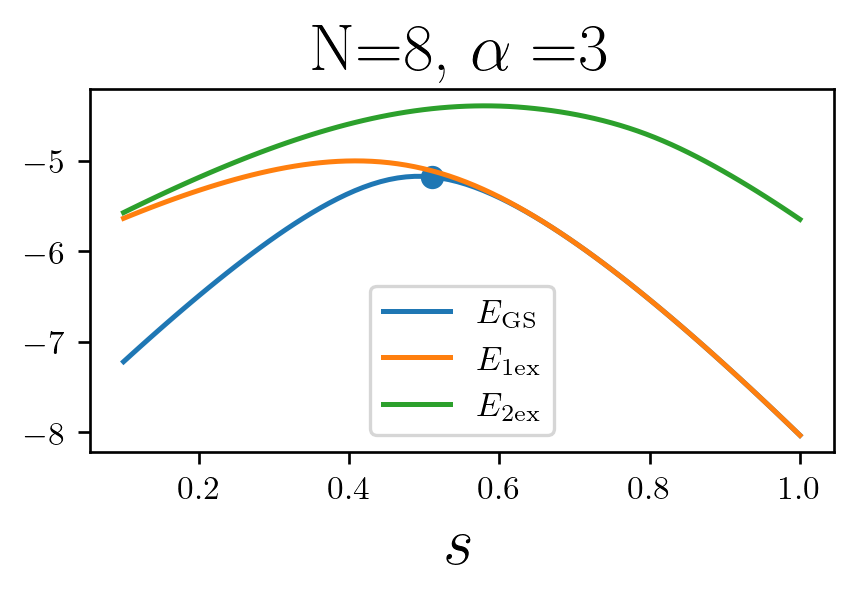

In [40]:
from scipy import sparse

N=8
gamma_list = np.linspace(0.1,1.0,10*N)
alpha=3

gs = []
first_ex = []
second_ex = []

for gamma in gamma_list:
    H =long_Ising_Hamiltonian_qml(float(gamma),float(alpha),N)
    H_mat = qml.utils.sparse_hamiltonian(H).real
    eigenvalue,eigenstate = get_ground_state(H_mat)
    gs.append(float(eigenvalue))
    H_mat +=  N*sparse.csr_matrix(np.matrix(eigenstate).T@np.matrix(eigenstate))
    eigenvalue,eigenstate = get_ground_state(H_mat)
    first_ex.append(float(eigenvalue))
    H_mat +=  N*sparse.csr_matrix(np.matrix(eigenstate).T@np.matrix(eigenstate))
    eigenvalue,eigenstate = get_ground_state(H_mat)
    second_ex.append(float(eigenvalue))
    
dif = np.abs(np.array(first_ex)-np.array(gs))
for i,element in enumerate(dif[:-1]):
    if element-dif[i+1] < 1/N**2:
        pos_transition = i
        break
print(f'The transition takes place at s={gamma_list[pos_transition]}')

fig,ax = plt.subplots()
fig.set_size_inches(4,2)
ax.plot(gamma_list,gs,label=r'$E_{\mathrm{GS}}$')
ax.plot(gamma_list,first_ex,label=r'$E_{\mathrm{1ex}}$')
ax.plot(gamma_list,second_ex,label=r'$E_{\mathrm{2ex}}$')
#ax.plot(gamma_list,dif)
ax.scatter(gamma_list[pos_transition],gs[pos_transition])
ax.set_xlabel(r'$s$',fontsize=20)

ax.legend(loc='best')#ax.legend(loc=6,fontsize=12)
#plt.setp(ax, ylim=ax1.get_ylim())
ax.set_title(r'N={0}, $\alpha=${1}'.format(N,alpha),fontsize=20) 


#plt.savefig("/home/ctabares/variational_long_range-main/paper/figures/figure_long_range_ferro/bands_N={:}_alpha={:}.pdf".format(N,alpha),bbox_inches='tight',dpi=600)



In [4]:
N=14
gamma_list = np.linspace(0.1,1.0,10*N)
print(gamma_list)
pos_transition = 17
print(gamma_list[pos_transition])

[0.1        0.10647482 0.11294964 0.11942446 0.12589928 0.1323741
 0.13884892 0.14532374 0.15179856 0.15827338 0.1647482  0.17122302
 0.17769784 0.18417266 0.19064748 0.1971223  0.20359712 0.21007194
 0.21654676 0.22302158 0.2294964  0.23597122 0.24244604 0.24892086
 0.25539568 0.2618705  0.26834532 0.27482014 0.28129496 0.28776978
 0.2942446  0.30071942 0.30719424 0.31366906 0.32014388 0.32661871
 0.33309353 0.33956835 0.34604317 0.35251799 0.35899281 0.36546763
 0.37194245 0.37841727 0.38489209 0.39136691 0.39784173 0.40431655
 0.41079137 0.41726619 0.42374101 0.43021583 0.43669065 0.44316547
 0.44964029 0.45611511 0.46258993 0.46906475 0.47553957 0.48201439
 0.48848921 0.49496403 0.50143885 0.50791367 0.51438849 0.52086331
 0.52733813 0.53381295 0.54028777 0.54676259 0.55323741 0.55971223
 0.56618705 0.57266187 0.57913669 0.58561151 0.59208633 0.59856115
 0.60503597 0.61151079 0.61798561 0.62446043 0.63093525 0.63741007
 0.64388489 0.65035971 0.65683453 0.66330935 0.66978417 0.67625

In [6]:
#pos_transition = int(5*N*0.9)-1
print(pos_transition,gamma_list[pos_transition])

17 0.21007194244604316


In [20]:
N=14
pos_transition = int(5*N*0.9)-1
print(pos_transition,gamma_list[pos_transition])

62 0.5014388489208633


In [21]:
energy_vec_global_layers = []
energy_vec_hva_layers = []
energy_vec_global_fixed_layers = []
energy_vec_global_all_to_all_layers = []
energy_vec_brick_cnot_layers = []
energy_vec_brick_cz_layers = []
energy_vec_hea_cnot_layers = []
energy_vec_hea_cz_layers = []

pos_vec_global_layers = []
params_opt_global_layers = []
pos_vec_global_fixed_layers = []
params_opt_global_fixed_layers = []
pos_vec_global_all_to_all_layers = []
params_opt_global_all_to_all_layers = []
pos_vec_hva_layers = []
params_opt_hva_layers = []
pos_vec_brick_cnot_layers = []
params_opt_brick_cnot_layers = []
pos_vec_brick_cz_layers = []
params_opt_brick_cz_layers = []
pos_vec_hea_cnot_layers = []
params_opt_hea_cnot_layers = []
pos_vec_hea_cz_layers = []
params_opt_hea_cz_layers = []
j=0


for layer in np.arange(1,11):
    
    energy_vec_global = []
    energy_vec_global_all_to_all = []
    energy_vec_global_fixed = []
    energy_vec_hva = []
    energy_vec_brick_cnot = []
    energy_vec_brick_cz = []
    energy_vec_hea_cnot = []
    energy_vec_hea_cz = []

    pos_vec_global = []
    params_opt_global = []
    pos_vec_global_all_to_all = []
    params_opt_global_all_to_all = []
    pos_vec_global_fixed = []
    params_opt_global_fixed = []
    pos_vec_hva = []
    params_opt_hva = []
    pos_vec_brick_cnot = []
    params_opt_brick_cnot = []
    pos_vec_brick_cz = []
    params_opt_brick_cz = []    
    pos_vec_hea_cnot = []
    params_opt_hea_cnot = []
    pos_vec_hea_cz = []
    params_opt_hea_cz = []

    i=pos_transition
    energy_vec_global.append(float(min(energy_history_list[j][0][i][0])))
    energy_vec_global_all_to_all.append(float(min(energy_history_list[j][7][i][0])))
    energy_vec_global_fixed.append(float(min(energy_history_list[j][6][i][0])))
    energy_vec_hva.append(float(min(energy_history_list[j][5][i][0])))
    energy_vec_brick_cnot.append(float(min(energy_history_list[j][1][i][0])))
    energy_vec_brick_cz.append(float(min(energy_history_list[j][2][i][0])))
    energy_vec_hea_cnot.append(float(min(energy_history_list[j][3][i][0])))
    energy_vec_hea_cz.append(float(min(energy_history_list[j][4][i][0])))


    pos_vec_global.append(energy_history_list[j][0][i][0].index(min(energy_history_list[j][0][i][0])))
    pos_vec_global_all_to_all.append(energy_history_list[j][7][i][0].index(min(energy_history_list[j][7][i][0])))
    pos_vec_global_fixed.append(energy_history_list[j][6][i][0].index(min(energy_history_list[j][6][i][0])))
    pos_vec_hva.append(energy_history_list[j][5][i][0].index(min(energy_history_list[j][5][i][0])))
    pos_vec_brick_cnot.append(energy_history_list[j][1][i][0].index(min(energy_history_list[j][1][i][0])))
    pos_vec_brick_cz.append(energy_history_list[j][2][i][0].index(min(energy_history_list[j][2][i][0])))
    pos_vec_hea_cnot.append(energy_history_list[j][3][i][0].index(min(energy_history_list[j][3][i][0])))
    pos_vec_hea_cz.append(energy_history_list[j][4][i][0].index(min(energy_history_list[j][4][i][0])))


    params_opt_global.append(params_history_list[j][0][i][0][pos_vec_global[0]])
    params_opt_global_all_to_all.append(params_history_list[j][7][i][0][pos_vec_global_all_to_all[0]])
    params_opt_global_fixed.append(params_history_list[j][6][i][0][pos_vec_global_fixed[0]])
    params_opt_hva.append(params_history_list[j][5][i][0][pos_vec_hva[0]])
    params_opt_brick_cnot.append(params_history_list[j][1][i][0][pos_vec_brick_cnot[0]])
    params_opt_brick_cz.append(params_history_list[j][2][i][0][pos_vec_brick_cz[0]])
    params_opt_hea_cnot.append(params_history_list[j][3][i][0][pos_vec_hea_cnot[0]])
    params_opt_hea_cz.append(params_history_list[j][4][i][0][pos_vec_hea_cz[0]])

    
    j+=1
    energy_vec_global_layers.append(energy_vec_global)   
    energy_vec_global_all_to_all_layers.append(energy_vec_global_all_to_all)     
    energy_vec_global_fixed_layers.append(energy_vec_global_fixed)    
    energy_vec_hva_layers.append(energy_vec_hva)
    energy_vec_brick_cnot_layers.append(energy_vec_brick_cnot)
    energy_vec_brick_cz_layers.append(energy_vec_brick_cz)
    energy_vec_hea_cnot_layers.append(energy_vec_hea_cnot)
    energy_vec_hea_cz_layers.append(energy_vec_hea_cz)

    pos_vec_global_layers.append(pos_vec_global)
    params_opt_global_layers.append(params_opt_global) 
    pos_vec_global_all_to_all_layers.append(pos_vec_global_all_to_all)
    params_opt_global_all_to_all_layers.append(params_opt_global_all_to_all) 
    pos_vec_global_fixed_layers.append(pos_vec_global_fixed)
    params_opt_global_fixed_layers.append(params_opt_global_fixed)    
    pos_vec_hva_layers.append(pos_vec_hva_layers)
    params_opt_hva_layers.append(params_opt_hva)
    pos_vec_brick_cnot_layers.append(pos_vec_brick_cnot)
    params_opt_brick_cnot_layers.append(params_opt_brick_cnot)
    pos_vec_brick_cz_layers.append(pos_vec_brick_cz)
    params_opt_brick_cz_layers.append(params_opt_brick_cz)
    pos_vec_hea_cnot_layers.append(pos_vec_hea_cnot)
    params_opt_hea_cnot_layers.append(params_opt_hea_cnot)
    pos_vec_hea_cz_layers.append(pos_vec_hea_cz)
    params_opt_hea_cz_layers.append(params_opt_hea_cz)

In [22]:
fidelity_global_layers = []
fidelity_global_fixed_layers = []
fidelity_global_all_to_all_layers = []

fidelity_hva_layers = []
fidelity_brick_cnot_layers = []
fidelity_brick_cz_layers = []
fidelity_hea_cnot_layers = []
fidelity_hea_cz_layers = []


# OPTIMIZATION: definition of the grid


#gamma_list = np.linspace(0.1,1.0,5*N)

eigenenergies_exact = []
eigenstates_exact = []
max_energy_exact = []

i=0
m=10*N

gamma_list = np.linspace(0.1,1.0,10*N)
gamma_pre =gamma_list[0:m][pos_transition]
gamma_in=gamma_pre
H =long_Ising_Hamiltonian_qml(float(gamma_in),float(alpha),N)
H_mat = qml.utils.sparse_hamiltonian(H).real
eigenvalue,eigenstate = get_ground_state(H_mat)
E_exac = float(eigenvalue)
eigenenergies_exact.append(E_exac)
eigenstates_exact.append(eigenstate)
H_max = -1*qml.utils.sparse_hamiltonian(H).real
eigenvalue_max,eigenstate_max = get_ground_state(H_max)
E_max = float(eigenvalue_max)
max_energy_exact.append(-E_max)
for layer in np.arange(1,int(11)):
    fidelity_global = []
    fidelity_global_fixed = []
    fidelity_global_all_to_all = []
    fidelity_hva = []
    fidelity_hea_cnot = []
    fidelity_hea_cz = []
    fidelity_brick_cnot = []
    fidelity_brick_cz = []
    i=-1
    fidelity_global.append(np.abs(energy_vec_global_layers[layer-1][i]-eigenenergies_exact[i])/(max_energy_exact[i]-eigenenergies_exact[i]))
    fidelity_global_all_to_all.append(np.abs(energy_vec_global_all_to_all_layers[layer-1][i]-eigenenergies_exact[i])/(max_energy_exact[i]-eigenenergies_exact[i]))
    fidelity_global_fixed.append(np.abs(energy_vec_global_fixed_layers[layer-1][i]-eigenenergies_exact[i])/(max_energy_exact[i]-eigenenergies_exact[i]))
    fidelity_hva.append(np.abs(energy_vec_hva_layers[layer-1][i]-eigenenergies_exact[i])/(max_energy_exact[i]-eigenenergies_exact[i]))
    fidelity_hea_cnot.append(np.abs(energy_vec_hea_cnot_layers[layer-1][i]-eigenenergies_exact[i])/(max_energy_exact[i]-eigenenergies_exact[i]))
    fidelity_hea_cz.append(np.abs(energy_vec_hea_cz_layers[layer-1][i]-eigenenergies_exact[i])/(max_energy_exact[i]-eigenenergies_exact[i]))
    fidelity_brick_cnot.append(np.abs(energy_vec_brick_cnot_layers[layer-1][i]-eigenenergies_exact[i])/(max_energy_exact[i]-eigenenergies_exact[i]))
    fidelity_brick_cz.append(np.abs(energy_vec_brick_cz_layers[layer-1][i]-eigenenergies_exact[i])/(max_energy_exact[i]-eigenenergies_exact[i]))

    fidelity_global_layers.append(fidelity_global)
    fidelity_global_all_to_all_layers.append(fidelity_global_all_to_all)
    fidelity_global_fixed_layers.append(fidelity_global_fixed)
    fidelity_hva_layers.append(fidelity_hva)
    fidelity_hea_cnot_layers.append(fidelity_hea_cnot)
    fidelity_brick_cz_layers.append(fidelity_brick_cz)
    fidelity_brick_cnot_layers.append(fidelity_brick_cnot)
    fidelity_hea_cz_layers.append(fidelity_hea_cz)

final_energy_global = []
final_energy_global_fixed = []
final_energy_global_all_to_all = []
final_energy_hva = []
final_energy_hea_cnot = []
final_energy_hea_cz = []
final_energy_brick_cnot = []
final_energy_brick_cz = []

for i in range(int(10)):
    final_energy_global.append(fidelity_global_layers[i][-1])
    final_energy_global_fixed.append(fidelity_global_fixed_layers[i][-1])
    final_energy_global_all_to_all.append(fidelity_global_all_to_all_layers[i][-1])
    final_energy_hva.append(fidelity_hva_layers[i][-1])
    final_energy_hea_cnot.append(fidelity_hea_cnot_layers[i][-1])
    final_energy_hea_cz.append(fidelity_hea_cz_layers[i][-1])
    final_energy_brick_cnot.append(fidelity_brick_cnot_layers[i][-1])
    final_energy_brick_cz.append(fidelity_brick_cz_layers[i][-1])

In [23]:
pos_transition

62

In [24]:
final_energies = [final_energy_global,final_energy_global_fixed,final_energy_brick_cnot,final_energy_brick_cz,
                final_energy_hea_cnot,final_energy_hea_cz,final_energy_hva,final_energy_global_all_to_all]
                
print(final_energies)

[[0.029426223370598113, 0.02629049572787745, 0.005705418437853347, 0.0024287662377654447, 0.0009469075705605581, 0.0009247684987406279, 0.0004197054683655182, 0.0002692968837512788, 0.0005054317228971681, 0.0002508065995920141], [0.03106363056186513, 0.019192526972786998, 0.0134089899665958, 0.01107148716900044, 0.006915806376103652, 0.005584181676208441, 0.0038562207979033524, 0.002427132528337731, 0.0020120437759692396, 0.0012710009630878033], [0.0015658709780201206, 0.0005270004633097845, 0.0003962139436418782, 0.00037944126733994977, 0.00036520731235663886, 0.00041180605309923293, 0.00017145613167771073, 0.0003464317070785609, 0.0003741351309975138, 0.00036837953591856734], [0.001696138746507222, 0.0005104830205602822, 0.00040816658263577893, 0.00037945275592558624, 0.0003623029351801535, 0.0002453666425340559, 0.00017781051644951768, 0.00015034588624491686, 2.7255586975795212e-05, 0.00040213245990995786], [0.1826443050351504, 0.14485273617240002, 0.20966773519594445, 0.24586822400

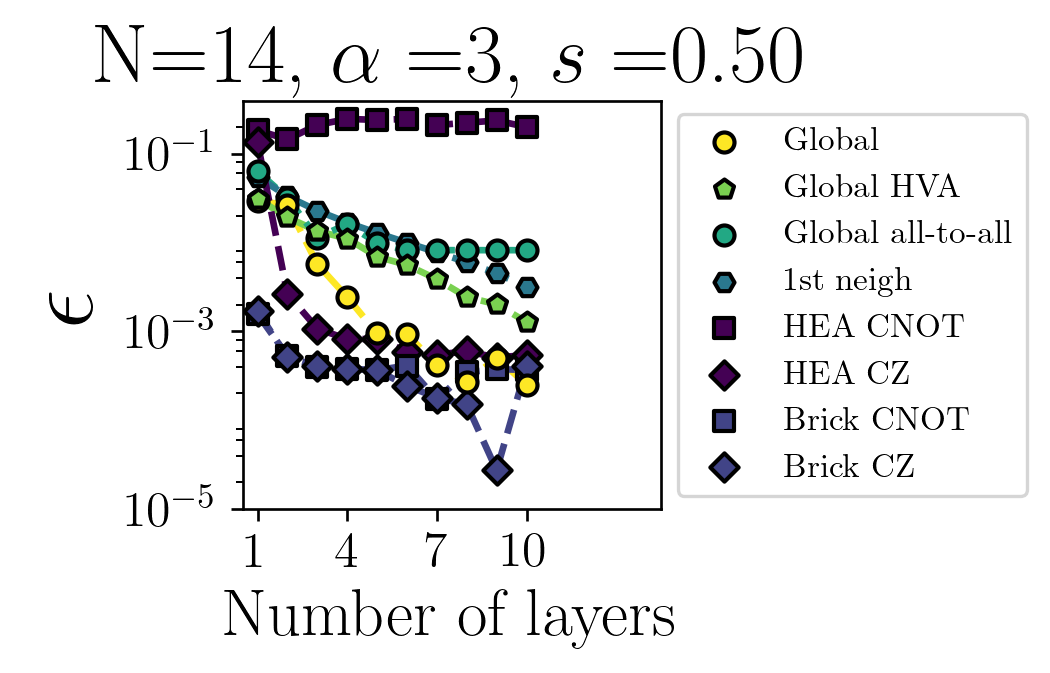

In [25]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(2.25,2.25)
M = 6
colors = plt.cm.viridis(np.linspace(0,1,M))
total_layers = np.arange(1,11)

ax.scatter(total_layers,final_energy_global,label=r'Global',linewidth=1.25,marker='o',edgecolor='black', facecolor=colors[-1],zorder=10)
ax.plot(total_layers,final_energy_global,linewidth=2,color=colors[-1],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_energy_global_fixed,label=r'Global HVA',linewidth=1.25,marker='p',edgecolor='black', facecolor=colors[-2],zorder=10)
ax.plot(total_layers,final_energy_global_fixed,linewidth=2,color=colors[-2],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_energy_global_all_to_all,label=r'Global all-to-all',linewidth=1.25,marker='o',edgecolor='black', facecolor=colors[-3],zorder=9)
ax.plot(total_layers,final_energy_global_all_to_all,linewidth=2,color=colors[-3],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_energy_hva,label=r'1st neigh',linewidth=1.25,marker='H',edgecolor='black', facecolor=colors[-4])
ax.plot(total_layers,final_energy_hva,linewidth=2,color=colors[-4],linestyle='dashed',zorder=-1)

ax.scatter(total_layers,final_energy_hea_cnot,label=r'HEA CNOT',linewidth=1.25,marker='s',edgecolor='black', facecolor=colors[0],zorder=-0.5)
ax.plot(total_layers,final_energy_hea_cnot,linewidth=2,color=colors[0],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_energy_hea_cz,label=r'HEA CZ',linewidth=1.25,marker='D',edgecolor='black', facecolor=colors[0],zorder=-0.5)
ax.plot(total_layers,final_energy_hea_cz,linewidth=2,color=colors[0],linestyle='dashed',zorder=-1)

ax.scatter(total_layers,final_energy_brick_cnot,label=r'Brick CNOT',linewidth=1.25,marker='s',edgecolor='black', facecolor=colors[1])
ax.plot(total_layers,final_energy_brick_cnot,linewidth=2,color=colors[1],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_energy_brick_cz,label=r'Brick CZ',linewidth=1.25,marker='D',edgecolor='black', facecolor=colors[1])
ax.plot(total_layers,final_energy_brick_cz,linewidth=2,color=colors[1],linestyle='dashed',zorder=-1)

#ax.scatter(total_layers[-1],final_energy_hva[-1],linewidth=1.25,marker='o',edgecolor='black', facecolor='white',alpha=0.65)
#ax.scatter(total_layers[-1],final_energy_cnot[-1],linewidth=1.25,marker='d',edgecolor='black', facecolor='white',alpha=0.65)
#ax.scatter(total_layers[-1],final_energy_cz[-1],linewidth=1.25,marker='D',edgecolor='black', facecolor='white',alpha=0.65)
ax.set_yscale('log')



#ax.set_xlim([3.2,0.2])
ax.set_title(r'N={0}, $\alpha=${1}, $s=${2:.2f}'.format(N,alpha,gamma_list[pos_transition]),fontsize=25) 
ax.set_xlabel(r'Number of layers',fontsize=20)
ax.set_ylabel(r"$\epsilon$",fontsize=30)
ax.tick_params(axis='both', labelsize=15)
#restore_minor_ticks_log_plot(ax)
from matplotlib import ticker as mticker
ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs=(.2, .4, .6, .8)))
ax.set_yticks([1e-1,1e-3,1e-5])
ax.set_yticklabels([r'$10^{-1}$',r'$10^{-3}$',r'$10^{-5}$'])
#ax.set_yticks([1e-0,1e-2,1e-4])
#ax.set_yticklabels([r'$10^{0}$',r'$10^{-2}$',r'$10^{-4}$'])
ax.set_xticks([1,4,7,10])
ax.set_xticklabels([r'$1$',r'$4$',r'$7$',r'$10$'])
ax.set_xlim([0.5,2*N/2+0.5])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1., box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))#ax.legend(loc=6,fontsize=12)
#plt.setp(ax, ylim=ax1.get_ylim())


#plt.savefig("/home/ctabares/variational_long_range-main/paper/figures/figure_long_range_ferro/residual-energy_N={0}_alpha={1}_s={2:.2f}.pdf".format(N,alpha,gamma_list[pos_transition]),bbox_inches='tight',dpi=600)

In [26]:
def approximating_exp(f,N,n,set_exp):

    import numpy as np
    import scipy

    if n>N:
        print('The condition N>>n is needed for convergence')
        return

    vec = np.arange(1,N+1)
    F = np.zeros((N-n+1,n))
    
    for i in range(n):
        F[:,i] = f(vec[i:N-n+i+1])

    U, V = np.linalg.qr(F)

    U1 = U[0:N-n,:]
    U2 = U[1:,:]

    L = np.matmul(np.linalg.pinv(U1),U2)
    eigval = np.linalg.eigvals(L)

    def func(x):
        suma = 0
        for k in np.arange(1,N+1):    
            product = x*(eigval**k)
            suma = suma + np.abs(f(vec[k-1])-np.sum(product))
        return suma

    x_in = 0.*np.random.random(n)
    res_1 = scipy.optimize.minimize(fun=func,x0=x_in,method='L-BFGS-B')

    if set_exp == True:
        return {'exponents': np.log(eigval), 'weights': res_1.x}
    else:
        return {'eigvals': eigval, 'weights': res_1.x}

def interaction(x):
    return 1/(x**alpha)

sol = approximating_exp(interaction,N,n=2,set_exp=True)

print('Weights: ',sol['weights'])
print('Exponents: ',sol['exponents'])
xi1 = float(1/(sol['exponents'][0]))
xi2 = float(1/(sol['exponents'][1]))

w1 = sol['weights'][0]
w2 = sol['weights'][1]

Weights:  [13.14977415  0.29584043]
Exponents:  [-2.72794745 -0.72742185]


In [27]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp

dev = qml.device('lightning.qubit', wires=N)
@qml.qnode(dev,interface='jax')
def circuit_global(params,layers):
    thetas = params[0:layers]
    xi = params[layers:2*layers]
    gamma = params[2*layers:3*layers]
    for i in range(N):
        qml.PauliX(wires=[i])
    for layer in range(layers):
        for i in range(N):
            for j in range(i+1,N):
                #qml.IsingXX(gamma[layer]*jnp.exp(-jnp.abs(i-j)/(xi[layer]**2)),wires=[i,j])
                qml.IsingXX(gamma[layer]*jnp.exp(-(jnp.abs(i-j)/jnp.abs(xi[layer]))),wires=[i,j])
        for i in range(N):
            qml.RZ(thetas[layer],i)
        qml.Barrier(range(0,N))
    return qml.state()

dev = qml.device('lightning.qubit', wires=N)
@qml.qnode(dev,interface='jax')
def circuit_hva(params,layers):
    thetas = params[0:layers]
    gamma = params[layers:2*layers]
    for i in range(N):
        qml.PauliX(wires=[i])
    for layer in range(layers):
        for i in range(N):
            for j in range(i+1,N):
                #qml.IsingXX(gamma[layer]*jnp.exp(-jnp.abs(i-j)/(xi[layer]**2)),wires=[i,j])
                qml.IsingXX(gamma[layer]*w1*jnp.exp(-(jnp.abs(i-j)/jnp.abs(xi1))),wires=[i,j])
                qml.IsingXX(gamma[layer]*w2*jnp.exp(-(jnp.abs(i-j)/jnp.abs(xi2))),wires=[i,j])
        for i in range(N):
            qml.RZ(thetas[layer],i)
        qml.Barrier(range(0,N))
    return qml.state()

dev = qml.device('lightning.qubit', wires=N)
@qml.qnode(dev,interface='jax')
def circuit_global_all_to_all(params,layers):
    thetas = params[0:layers]
    gamma = params[layers:2*layers]
    for i in range(N):
        qml.PauliX(wires=[i])
    for layer in range(layers):
        for i in range(N):
            for j in range(i+1,N):
                #qml.IsingXX(gamma[layer]*jnp.exp(-jnp.abs(i-j)/(xi[layer]**2)),wires=[i,j])
                qml.IsingXX(gamma[layer],wires=[i,j])
        for i in range(N):
            qml.RZ(thetas[layer],i)
        qml.Barrier(range(0,N))
    return qml.state()

dev = qml.device('lightning.qubit', wires=N)
@qml.qnode(dev,interface='jax')
def circuit_1st(params,layers):
    thetas = params[0:layers]
    gamma = params[1*layers:2*layers]
    for i in range(N):
        qml.PauliX(wires=[i])
    for layer in range(layers):
        for i in range(N-1):
            j=i+1
            qml.IsingXX(gamma[layer],wires=[i,j])
        for i in range(N):
            qml.RZ(thetas[layer],i)
        qml.Barrier(range(0,N))
    return qml.state()

dev = qml.device('lightning.qubit',wires=N)
@qml.qnode(dev,interface='jax')
def circuit_brick_cnot(params,layers):
    for layer in range(layers):
        for i in range(N):
            qml.RY(params[2*layer*N+i],i)
        for i in range(int(N/2)):
            qml.CNOT(wires=[2*i,2*i+1])
        for i in range(N):
            qml.RY(params[2*layer*N+N+i],i)
        for i in range(1,int(N/2)):
            qml.CNOT(wires=[2*i-1,2*i])
        qml.CNOT(wires=[N-1,0])
        qml.Barrier(range(0,N))
    for i in range(N):
        qml.RY(params[2*N*layers+i],i)
    qml.Barrier(range(0,N))
    return qml.state()

dev = qml.device('lightning.qubit', wires=N)
@qml.qnode(dev,interface='jax')
def circuit_brick_cz(params,layers):
    for layer in range(layers):
        for i in range(N):
            qml.RY(params[2*layer*N+i],i)
        for i in range(int(N/2)):
            qml.CZ(wires=[2*i,2*i+1])
        for i in range(N):
            qml.RY(params[2*layer*N+N+i],i)
        for i in range(1,int(N/2)):
            qml.CZ(wires=[2*i-1,2*i])
        qml.CZ(wires=[N-1,0])
        qml.Barrier(range(0,N))
    for i in range(N):
        qml.RY(params[2*N*layers+i],i)
    qml.Barrier(range(0,N))
    return qml.state()

dev = qml.device('lightning.qubit', wires=N)
@qml.qnode(dev,interface='jax')
def circuit_hea_cnot(params,layers):
    for layer in range(layers):
        for i in range(N):
            qml.RZ(params[layer*N+i],i)
            qml.RX(params[layers*N+layer*N+i],i)
            qml.RZ(params[2*layers*N+layer*N+i],i)
        for i in range(N-1):
            qml.CNOT(wires=[i,i+1])
        qml.CNOT(wires=[N-1,0])
        qml.Barrier(range(0,N))
    return qml.state()

dev = qml.device('lightning.qubit', wires=N)
@qml.qnode(dev,interface='jax')
def circuit_hea_cz(params,layers):
    for layer in range(layers):
        for i in range(N):
            qml.RZ(params[layer*N+i],i)
            qml.RX(params[layers*N+layer*N+i],i)
            qml.RZ(params[2*layers*N+layer*N+i],i)
        for i in range(N-1):
            qml.CZ(wires=[i,i+1])
        qml.CZ(wires=[N-1,0])
        qml.Barrier(range(0,N))
    return qml.state()

In [28]:
state_fidelity_global_layers = []
state_fidelity_global_all_to_all_layers = []
state_fidelity_global_fixed_layers = []
state_fidelity_hva_layers = []
state_fidelity_hea_cnot_layers = []
state_fidelity_hea_cz_layers = []
state_fidelity_brick_cnot_layers = []
state_fidelity_brick_cz_layers = []


for layer in np.arange(1,int(11)):

    state_fidelity_global = []
    state_fidelity_global_all_to_all = []
    state_fidelity_global_fixed = []
    state_fidelity_hva = []
    state_fidelity_hea_cnot = []
    state_fidelity_hea_cz = []
    state_fidelity_brick_cnot = []
    state_fidelity_brick_cz = []
    i=-1
        
    eigenvalue=eigenenergies_exact[i]
    eigenstate=eigenstates_exact[i]

    par_global = params_opt_global_layers[layer-1][i]
    numeric_global = circuit_global(par_global,layer)
    state_fidelity_global.append(1-np.abs(np.vdot(eigenstate,numeric_global)))

    par_global = params_opt_global_all_to_all_layers[layer-1][i]
    numeric_global_all_to_all = circuit_global_all_to_all(par_global,layer)
    state_fidelity_global_all_to_all.append(1-np.abs(np.vdot(eigenstate,numeric_global_all_to_all)))

    par_hva = params_opt_global_fixed_layers[layer-1][i]
    numeric_hva = circuit_hva(par_hva,layer)
    state_fidelity_global_fixed.append(1-np.abs(np.vdot(eigenstate,numeric_hva)))

    par_1st = params_opt_hva_layers[layer-1][i]
    numeric_1st = circuit_1st(par_1st,layer)
    state_fidelity_hva.append(1-np.abs(np.vdot(eigenstate,numeric_1st)))

    par_hea_cnot = params_opt_hea_cnot_layers[layer-1][i]
    numeric_hea_cnot = circuit_hea_cnot(par_hea_cnot,layer)
    state_fidelity_hea_cnot.append(1-np.abs(np.vdot(eigenstate,numeric_hea_cnot)))

    par_brick_cnot = params_opt_brick_cnot_layers[layer-1][i]
    numeric_brick_cnot = circuit_brick_cnot(par_brick_cnot,layer)
    state_fidelity_brick_cnot.append(1-np.abs(np.vdot(eigenstate,numeric_brick_cnot)))
    
    par_hea_cz = params_opt_hea_cz_layers[layer-1][i]
    numeric_hea_cz = circuit_hea_cz(par_hea_cz,layer)
    state_fidelity_hea_cz.append(1-np.abs(np.vdot(eigenstate,numeric_hea_cz)))

    par_brick_cz = params_opt_brick_cz_layers[layer-1][i]
    numeric_brick_cz = circuit_brick_cz(par_brick_cz,layer)
    state_fidelity_brick_cz.append(1-np.abs(np.vdot(eigenstate,numeric_brick_cz)))

    state_fidelity_global_layers.append(state_fidelity_global)
    state_fidelity_global_fixed_layers.append(state_fidelity_global_fixed)
    state_fidelity_global_all_to_all_layers.append(state_fidelity_global_all_to_all)
    state_fidelity_hva_layers.append(state_fidelity_hva)
    state_fidelity_hea_cnot_layers.append(state_fidelity_hea_cnot)
    state_fidelity_hea_cz_layers.append(state_fidelity_hea_cz)
    state_fidelity_brick_cnot_layers.append(state_fidelity_brick_cnot)
    state_fidelity_brick_cz_layers.append(state_fidelity_brick_cz)

final_state_global = []
final_state_global_fixed = []
final_state_global_all_to_all = []
final_state_hva = []
final_state_hea_cnot = []
final_state_hea_cz = []
final_state_brick_cnot = []
final_state_brick_cz = []

for i in range(int(10)):
    final_state_global.append(state_fidelity_global_layers[i][-1])
    final_state_global_fixed.append(state_fidelity_global_fixed_layers[i][-1])
    final_state_global_all_to_all.append(state_fidelity_global_all_to_all_layers[i][-1])
    final_state_hva.append(state_fidelity_hva_layers[i][-1])
    final_state_hea_cnot.append(state_fidelity_hea_cnot_layers[i][-1])
    final_state_hea_cz.append(state_fidelity_hea_cz_layers[i][-1])
    final_state_brick_cnot.append(state_fidelity_brick_cnot_layers[i][-1])
    final_state_brick_cz.append(state_fidelity_brick_cz_layers[i][-1])

In [29]:
final_states = [final_state_global,final_state_global_fixed,final_state_brick_cnot,final_state_brick_cz,
                final_state_hea_cnot,final_state_hea_cz,final_state_hva,final_state_global_all_to_all]

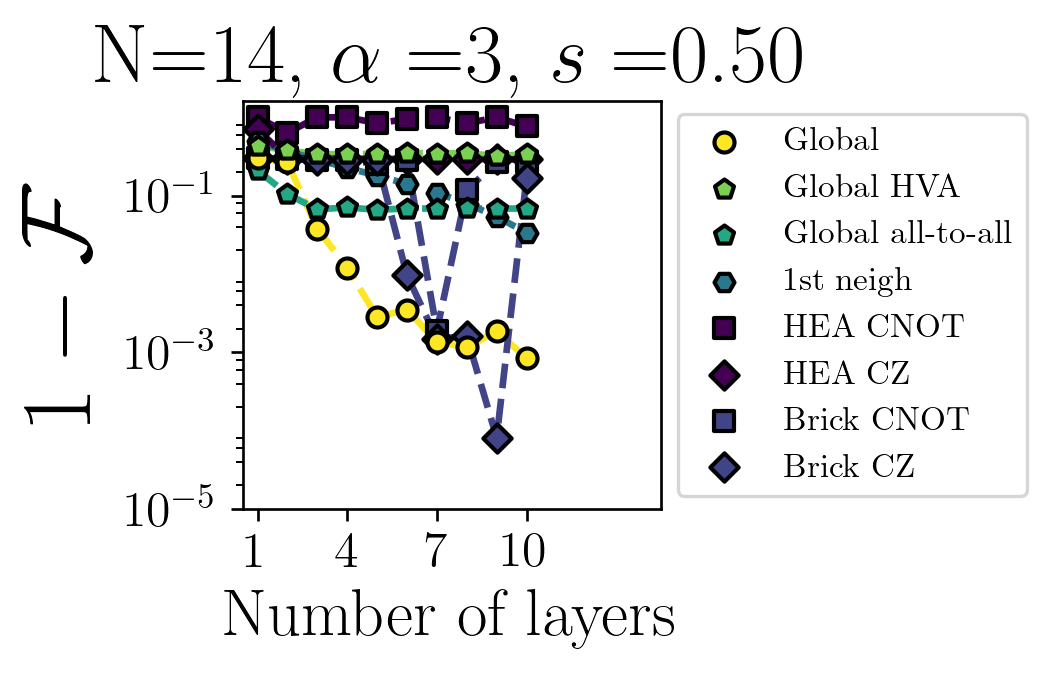

In [30]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(2.25,2.25)
M = 6
colors = plt.cm.viridis(np.linspace(0,1,M))
total_layers = np.arange(1,11)

ax.scatter(total_layers,final_state_global,label=r'Global',linewidth=1.25,marker='o',edgecolor='black', facecolor=colors[-1],zorder=10)
ax.plot(total_layers,final_state_global,linewidth=2,color=colors[-1],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_state_global_fixed,label=r'Global HVA',linewidth=1.25,marker='p',edgecolor='black', facecolor=colors[-2],zorder=10)
ax.plot(total_layers,final_state_global_fixed,linewidth=2,color=colors[-2],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_state_global_all_to_all,label=r'Global all-to-all',linewidth=1.25,marker='p',edgecolor='black', facecolor=colors[-3],zorder=9)
ax.plot(total_layers,final_state_global_all_to_all,linewidth=2,color=colors[-3],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_state_hva,label=r'1st neigh',linewidth=1.25,marker='H',edgecolor='black', facecolor=colors[-4])
ax.plot(total_layers,final_state_hva,linewidth=2,color=colors[-4],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_state_hea_cnot,label=r'HEA CNOT',linewidth=1.25,marker='s',edgecolor='black', facecolor=colors[0],zorder=-0.5)
ax.plot(total_layers,final_state_hea_cnot,linewidth=2,color=colors[0],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_state_hea_cz,label=r'HEA CZ',linewidth=1.25,marker='D',edgecolor='black', facecolor=colors[0],zorder=-0.5)
ax.plot(total_layers,final_state_hea_cz,linewidth=2,color=colors[0],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_state_brick_cnot,label=r'Brick CNOT',linewidth=1.25,marker='s',edgecolor='black', facecolor=colors[1])
ax.plot(total_layers,final_state_brick_cnot,linewidth=2,color=colors[1],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_state_brick_cz,label=r'Brick CZ',linewidth=1.25,marker='D',edgecolor='black', facecolor=colors[1])
ax.plot(total_layers,final_state_brick_cz,linewidth=2,color=colors[1],linestyle='dashed',zorder=-1)

ax.set_yscale('log')



#ax.set_xlim([3.2,0.2])
ax.set_title(r'N={0}, $\alpha=${1}, $s=${2:.2f}'.format(N,alpha,gamma_list[pos_transition]),fontsize=25) 
ax.set_xlabel(r'Number of layers',fontsize=20)
ax.set_ylabel(r"$1-\mathcal{F}$",fontsize=30)
ax.tick_params(axis='both', labelsize=15)
#restore_minor_ticks_log_plot(ax)
from matplotlib import ticker as mticker
ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs=(.2, .4, .6, .8)))
ax.set_yticks([1e-1,1e-3,1e-5])
ax.set_yticklabels([r'$10^{-1}$',r'$10^{-3}$',r'$10^{-5}$'])
ax.set_xticks([1,4,7,10])
ax.set_xticklabels([r'$1$',r'$4$',r'$7$',r'$10$'])
ax.set_xlim([0.5,2*N/2+0.5])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1., box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))#ax.legend(loc=6,fontsize=12)
#plt.setp(ax, ylim=ax1.get_ylim())


#plt.savefig("/home/ctabares/variational_long_range-main/paper/figures/figure_long_range_ferro/state-infidelity_N={0}_alpha={1}_s={2:.2f}.pdf".format(N,alpha,gamma_list[pos_transition]),bbox_inches='tight',dpi=600)

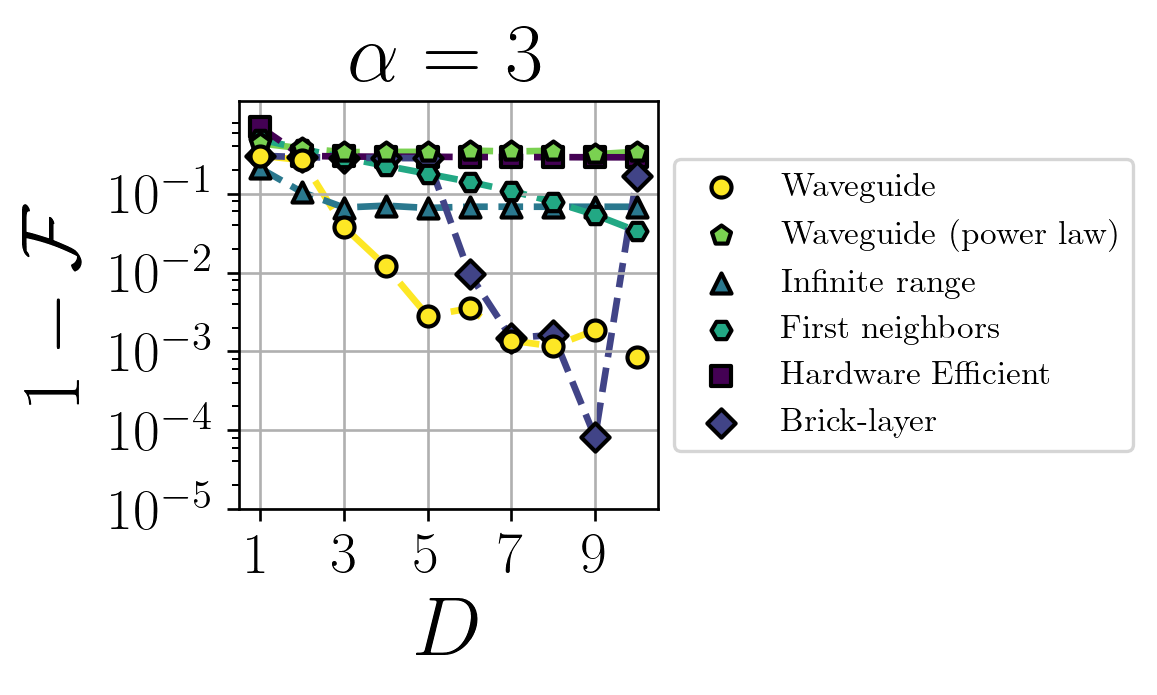

In [16]:
from fractions import Fraction
fig,ax = plt.subplots(1,1)
fig.set_size_inches(2.25,2.25)
M = 6
colors = plt.cm.viridis(np.linspace(0,1,M))
total_layers = np.arange(1,11)
plt.grid()
ax.scatter(total_layers,final_state_global,label=r'Waveguide',linewidth=1.25,marker='o',edgecolor='black', facecolor=colors[-1],zorder=15)
ax.plot(total_layers,final_state_global,linewidth=2,color=colors[-1],linestyle=(0, (5, 5)),zorder=-1)
ax.scatter(total_layers,final_state_global_fixed,label=r'Waveguide (power law)',linewidth=1.25,marker='p',edgecolor='black', facecolor=colors[-2],zorder=14)
ax.plot(total_layers,final_state_global_fixed,linewidth=2,color=colors[-2],linestyle=(0, (5, 5)),zorder=-1)
ax.scatter(total_layers,final_state_global_all_to_all,label=r'Infinite range',linewidth=1.25,marker='^',edgecolor='black', facecolor=colors[-4],zorder=10)
ax.plot(total_layers,final_state_global_all_to_all,linewidth=2,color=colors[-4],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_state_hva,label=r'First neighbors',linewidth=1.25,marker='H',edgecolor='black', facecolor=colors[-3],zorder=10)
ax.plot(total_layers,final_state_hva,linewidth=2,color=colors[-3],linestyle='dashed',zorder=-1)
#ax.scatter(total_layers,final_state_hea_cnot,label=r'HEA CNOT',linewidth=1.25,marker='s',edgecolor='black', facecolor=colors[0],zorder=2)
#ax.plot(total_layers,final_state_hea_cnot,linewidth=2,color=colors[0],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_state_hea_cz,label=r'Hardware Efficient',linewidth=1.25,marker='s',edgecolor='black', facecolor=colors[0],zorder=2)
ax.plot(total_layers,final_state_hea_cz,linewidth=2,color=colors[0],linestyle='dashed',zorder=-1)
#ax.scatter(total_layers,final_state_brick_cnot,label=r'Brick CNOT',linewidth=1.25,marker='s',edgecolor='black', facecolor=colors[1],zorder=2)
#ax.plot(total_layers,final_state_brick_cnot,linewidth=2,color=colors[1],linestyle='dashed',zorder=-1)
ax.scatter(total_layers,final_state_brick_cz,label=r'Brick-layer',linewidth=1.25,marker='D',edgecolor='black', facecolor=colors[1],zorder=2)
ax.plot(total_layers,final_state_brick_cz,linewidth=2,color=colors[1],linestyle='dashed',zorder=-1)

ax.set_yscale('log')



#ax.set_xlim([3.2,0.2])
ax.set_title(r'$\alpha={:}$ '.format(Fraction(alpha)),fontsize=25)
ax.set_xlabel(r'$D$',fontsize=25)
ax.set_ylabel(r"$1-\mathcal{F}$",fontsize=25)
ax.tick_params(axis='both', labelsize=17.5)
#restore_minor_ticks_log_plot(ax)
from matplotlib import ticker as mticker
ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs=(.2, .4, .6, .8)))
ax.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5])
ax.set_yticklabels([r'$10^{-1}$',r'$10^{-2}$',r'$10^{-3}$',r'$10^{-4}$',r'$10^{-5}$'])
ax.set_xticks([1,3,5,7,9])
ax.set_xticklabels([r'$1$',r'$3$',r'$5$',r'$7$',r'$9$'])
ax.set_xlim([0.5,10+0.5])
ax.set_ylim([1e-5,1.5])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1., box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))#ax.legend(loc=6,fontsize=12)
#plt.setp(ax, ylim=ax1.get_ylim())

#plt.savefig("figures/figure_long_range_ferro/def_final_state_infidelity_N={:}_alpha={:}_no.pdf".format(N,alpha),bbox_inches='tight',dpi=600)

In [54]:
residual_energy_layers = {}
infidelity_layers = {}
gates = ['global_adiab','brick-cnot_adiab_finrot','brick-cz_adiab_finrot','hea-cnot_adiab','hea-cz_adiab','1st-neigh_adiab','global_fixed-alpha_adiab','global_all-to-all_adiab']
for i,layer in enumerate(np.arange(1,int(10)+1)):
    residual_energy_gates = {}
    infidelity_gates = {}
    for j,gate in enumerate(gates):
        residual_energy_gates[f'{gate}']= final_energies[j][i]
        infidelity_gates[f'{gate}'] = final_states[j][i]
        print(f'gate={gate} for layer={layer}')
    residual_energy_layers[f'layers={layer}'] = residual_energy_gates
    infidelity_layers[f'layers={layer}'] = infidelity_gates
    

gate=global_adiab for layer=1
gate=brick-cnot_adiab_finrot for layer=1
gate=brick-cz_adiab_finrot for layer=1
gate=hea-cnot_adiab for layer=1
gate=hea-cz_adiab for layer=1
gate=1st-neigh_adiab for layer=1
gate=global_fixed-alpha_adiab for layer=1
gate=global_all-to-all_adiab for layer=1
gate=global_adiab for layer=2
gate=brick-cnot_adiab_finrot for layer=2
gate=brick-cz_adiab_finrot for layer=2
gate=hea-cnot_adiab for layer=2
gate=hea-cz_adiab for layer=2
gate=1st-neigh_adiab for layer=2
gate=global_fixed-alpha_adiab for layer=2
gate=global_all-to-all_adiab for layer=2
gate=global_adiab for layer=3
gate=brick-cnot_adiab_finrot for layer=3
gate=brick-cz_adiab_finrot for layer=3
gate=hea-cnot_adiab for layer=3
gate=hea-cz_adiab for layer=3
gate=1st-neigh_adiab for layer=3
gate=global_fixed-alpha_adiab for layer=3
gate=global_all-to-all_adiab for layer=3
gate=global_adiab for layer=4
gate=brick-cnot_adiab_finrot for layer=4
gate=brick-cz_adiab_finrot for layer=4
gate=hea-cnot_adiab for la

In [55]:
residual_energy_layers['layers=1']['global_adiab']

0.23866467318323775

In [42]:
residual_energy_pos = {}
infidelity_pos = {}
residual_energy_pos['s=critical'] = residual_energy_layers
infidelity_pos['s=critical'] = infidelity_layers

In [56]:
residual_energy_pos['s=0.5'] = residual_energy_layers
infidelity_pos['s=0.5'] = infidelity_layers

In [58]:
#residual_energy_alpha = {}
#infidelity_alpha = {}

residual_energy_alpha[f'alpha={alpha}'] = residual_energy_pos
infidelity_alpha[f'alpha={alpha}'] = infidelity_pos

In [59]:
infidelity_alpha['alpha=0.5']['s=0.5']

{'layers=1': {'global_adiab': 0.30913918019893294,
  'brick-cnot_adiab_finrot': 0.3855832856357829,
  'brick-cz_adiab_finrot': 0.2929000286873896,
  'hea-cnot_adiab': 0.29289944405803403,
  'hea-cz_adiab': 0.319310545775924,
  '1st-neigh_adiab': 0.867744560197862,
  'global_fixed-alpha_adiab': 0.8146350621735926,
  'global_all-to-all_adiab': 0.30748996621675606},
 'layers=2': {'global_adiab': 0.07900124267027064,
  'brick-cnot_adiab_finrot': 0.1594779392044,
  'brick-cz_adiab_finrot': 0.2928977532985344,
  'hea-cnot_adiab': 0.2929009546347747,
  'hea-cz_adiab': 0.31267156007454777,
  '1st-neigh_adiab': 0.29290448801761115,
  'global_fixed-alpha_adiab': 0.6913014070624082,
  'global_all-to-all_adiab': 0.12822104103011844},
 'layers=3': {'global_adiab': 0.01046400117821078,
  'brick-cnot_adiab_finrot': 0.04007314824434449,
  'brick-cz_adiab_finrot': 0.2928970585511306,
  'hea-cnot_adiab': 0.2928985559648771,
  'hea-cz_adiab': 0.6157531976842798,
  '1st-neigh_adiab': 0.2928996307269097,
 

In [515]:
#residual_energy_data = {}
#infidelity_data = {}

In [61]:
residual_energy_data[f'N={N}'] = residual_energy_alpha
infidelity_data[f'N={N}'] = infidelity_alpha

In [63]:
residual_energy_data['N=12']

{'alpha=0.5': {'s=critical': {'layers=1': {'global_adiab': 0.03354217228864674,
    'brick-cnot_adiab_finrot': 0.04109128896243564,
    'brick-cz_adiab_finrot': 0.001331703278149842,
    'hea-cnot_adiab': 0.0013328071182824824,
    'hea-cz_adiab': 0.12110838421750579,
    '1st-neigh_adiab': 0.09206566042765371,
    'global_fixed-alpha_adiab': 0.08479691914755547,
    'global_all-to-all_adiab': 0.03427857163713447},
   'layers=2': {'global_adiab': 0.012197721570506597,
    'brick-cnot_adiab_finrot': 0.01689304355470916,
    'brick-cz_adiab_finrot': 0.0010955734764425142,
    'hea-cnot_adiab': 0.001293988740284628,
    'hea-cz_adiab': 0.025765250607484174,
    '1st-neigh_adiab': 0.001503902338841746,
    'global_fixed-alpha_adiab': 0.07854154910255999,
    'global_all-to-all_adiab': 0.012901741608436877},
   'layers=3': {'global_adiab': 0.00218763931433476,
    'brick-cnot_adiab_finrot': 0.005260086336861621,
    'brick-cz_adiab_finrot': 0.0009150496214169473,
    'hea-cnot_adiab': 0.000

In [519]:
residual_energy_data[f'N={N}']['alpha=1']['s=critical']['layers=7']

{'global_adiab': 0.00014157932121473243,
 'brick-cnot_adiab_finrot': 5.0506875787386636e-05,
 'brick-cz_adiab_finrot': 0.00047374319708200636,
 'hea-cnot_adiab': 0.00047440317272593683,
 'hea-cz_adiab': 0.08619249290921667,
 '1st-neigh_adiab': 0.0013908509232136393,
 'global_fixed-alpha_adiab': 0.011669371712816021,
 'global_all-to-all_adiab': 0.002892626167594506}

In [520]:
import pickle

with open('./residual_energy_long-range_ferro_dict.p', 'wb') as fp:
    pickle.dump(residual_energy_data, fp)

with open('./state_infidelity_long-range_ferro_dict.p', 'wb') as fp:
    pickle.dump(infidelity_data, fp)

In [60]:
import pickle
with open('/home/ctabares/variational_long_range-main/paper//residual_energy_long-range_ferro_dict.p','rb') as fp:
    residual_energy_data = pickle.load(fp)

with open('/home/ctabares/variational_long_range-main/paper//state_infidelity_long-range_ferro_dict.p','rb') as fp:
    infidelity_data = pickle.load(fp)

In [9]:
residual_energies[f'N={N}']['alpha=1']['s=critical']['layers=7']

{'global_adiab': 5.417869601153636e-05,
 'brick-cnot_adiab_finrot': 2.6803031231404284e-05,
 'brick-cz_adiab_finrot': 0.0005670893427667797,
 'hea-cnot_adiab': 0.0002007419557391278,
 'hea-cz_adiab': 0.0270434071986612,
 '1st-neigh_adiab': 0.0025631046281686647,
 'global_fixed-alpha_adiab': 0.002534093393967551,
 'global_all-to-all_adiab': 0.002852165133810611}

In [21]:
state_infidelities['N=10']['alpha=1']['s=critical']['layers=8']

{'global_adiab': 0.00019789571705364217,
 'brick-cnot_adiab_finrot': 0.00018821954561187848,
 'brick-cz_adiab_finrot': 0.0010360917376719403,
 'hea-cnot_adiab': 0.0004570190707181565,
 'hea-cz_adiab': 0.6065289284237716,
 '1st-neigh_adiab': 0.28713699643723634,
 'global_fixed-alpha_adiab': 0.01403012046291241,
 'global_all-to-all_adiab': 0.009124095488588613}

In [120]:
infidelity_data['N=10']['layers=5']

{'global_adiab': 0.0012711492641905853,
 'brick-cnot_adiab_finrot': 0.00041197475878718137,
 'brick-cz_adiab_finrot': 0.010941951027969576,
 'hea-cnot_adiab': 0.6426650270876533,
 'hea-cz_adiab': 0.17108676509636023,
 'HVA_adiab': 0.00787700729479901}

In [121]:
infidelity_data['N=12']['layers=12']

{'global_adiab': 0.00022607658557882715,
 'brick-cnot_adiab_finrot': 0.0010624088851125535,
 'brick-cz_adiab_finrot': 4.791882384747037e-05,
 'hea-cnot_adiab': 0.8803895279284228,
 'hea-cz_adiab': 0.008429478509663246,
 'HVA_adiab': 3.666470840535396e-05}

In [122]:
infidelity_data['N=14']['layers=7']

{'global_adiab': 0.0007066296521563986,
 'brick-cnot_adiab_finrot': 0.0009970307100152231,
 'brick-cz_adiab_finrot': 0.017236523251341285,
 'hea-cnot_adiab': 0.9999998727897316,
 'hea-cz_adiab': 0.22769170328514932,
 'HVA_adiab': 0.009157358204583188}

In [139]:
infidelity_data['N=16']['layers=4']['global_adiab']

0.010837448785015469

In [8]:
import pickle
with open('/home/ctabares/variational_long_range-main/paper//residual_energy_long-range_ferro_dict_final.p','rb') as fp:
    residual_energy_data = pickle.load(fp)

with open('/home/ctabares/variational_long_range-main/paper//state_infidelity_long-range_ferro_dict_final.p','rb') as fp:
    infidelity_data = pickle.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ctabares/variational_long_range-main/paper//residual_energy_long-range_ferro_dict_final.p'